## Voronoi Analysis of Madrid metro stations

### Bibliography

##### - https://ipython-books.github.io/145-computing-the-voronoi-diagram-of-a-set-of-points/
##### - https://gist.github.com/nishadhka/3ba801ca980da5b76004631c1935f604


### TODO:
        - Bad-Character replacement (ü, ñ, etc.) (ISO-8859-1 to utf-8/unicode format)
        - Add District to each station for population/density analysis

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial as spatial
import matplotlib.pyplot as plt
#import matplotlib.path as path
import matplotlib as mpl
import smopy

In [2]:
import pykml
import urllib.request
from pykml import parser

In [3]:
filename = '../Metro_2018_09.kml' # Official data provided by Madrid council house (source: https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=08055cde99be2410VgnVCM1000000b205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)
with open(filename, encoding = "ISO-8859-1") as f:
    folder = parser.parse(f).getroot().Document.Folder

In [4]:
stations = []
coordinates = []
for pm in folder.Placemark:
    plnm1 = pm.name
    plcs1 = pm.Point.coordinates
    stations.append(plnm1.text)
    coordinates.append(plcs1.text)
    
df = pd.DataFrame()
df['place_name'] = stations
df['cordinates'] = coordinates

In [5]:
df['Altitud'], df['Latitud'] = df['cordinates'].str.split('\n', 1).replace(',','').str

In [6]:
df['Altitud'] = df['Altitud'].str.replace(',','').astype(float)
df['Latitud'] = df['Latitud'].str.replace(',','').astype(float)

In [7]:
df['Estacion'] = df['place_name'].str.split(' ',1).str[-1]

In [8]:
df['Linea'] = df['place_name'].str.split(' ',1).str[0]

In [9]:
df = df.drop(['cordinates', 'place_name'], 1)

In [10]:
lista = (df[df['Linea'] == '9']['Estacion'].values)

In [11]:
# Reorder columns
cols = ['Linea', 'Estacion', 'Latitud','Altitud']
df = df[cols]
#df2 = df.copy()

In [12]:
df.head()

,Linea,Estacion,Latitud,Altitud
0,1,ALTO DEL ARENAL,40.389769,-3.645225
1,1,ALVARADO,40.450331,-3.703318
2,1,ANTON MARTIN,40.412463,-3.699376
3,1,ATOCHA,40.408847,-3.692491
4,1,ATOCHA RENFE,40.406586,-3.689380


In [13]:
different_stations = df['Estacion'].unique()

In [14]:
df[df['Estacion'] == 'SOL']

,Linea,Estacion,Latitud,Altitud
26,1,SOL,40.416872,-3.703264
118,2,SOL,40.416845,-3.703264
134,3,SOL,40.416809,-3.703263


In [15]:
repeated_stations = []

for station in different_stations:
    if len(df[df['Estacion'] == station]) > 1:
        repeated_stations.append(station)

In [16]:
duplicados = set([x for x in df['Estacion'].tolist() if df['Estacion'].tolist().count(x) > 1])

In [17]:
repetidas = [x for x in df['Estacion'] if x not in different_stations]

In [18]:
def Unify_Stations(df, stations, field='Estacion'):
    # This function receives a DataFrame and a list of stations with more than one line passing by them
    # And sets the coordinates for each station to be the same 
    for station in stations:
        for i in range(len(df[df[field] == station])):
            df.iloc[df[df[field]==station].index[i],
                    df.columns.get_loc('Latitud')] = df.iloc[df[df[field]==station].index[0],
                                                             df.columns.get_loc('Latitud')]
            df.iloc[df[df[field]==station].index[i],
                    df.columns.get_loc('Altitud')] = df.iloc[df[df[field]==station].index[0],
                                                             df.columns.get_loc('Altitud')]
    return df

In [19]:
df = Unify_Stations(df, repeated_stations)

#### ________________
#### Pasado hasta aquí a VSCode

### We represent Madrid map in order to draw the Voronoi Areas

In [20]:
# We obtain the limits of the map

lat_min = (min(df['Latitud']))
lat_max = (max(df['Latitud']))
lon_min = (min(df['Altitud']))
lon_max = (max(df['Altitud']))

In [21]:
lat_min_new = df[df['Estacion'] == 'MARQUES DE VADILLO']['Latitud']
lon_min_new = df[df['Estacion'] == 'MARQUES DE VADILLO']['Altitud']
lat_max_new = df[df['Estacion'] == 'CHAMARTIN']['Latitud']
lon_max_new = df[df['Estacion'] == 'CHAMARTIN']['Altitud']

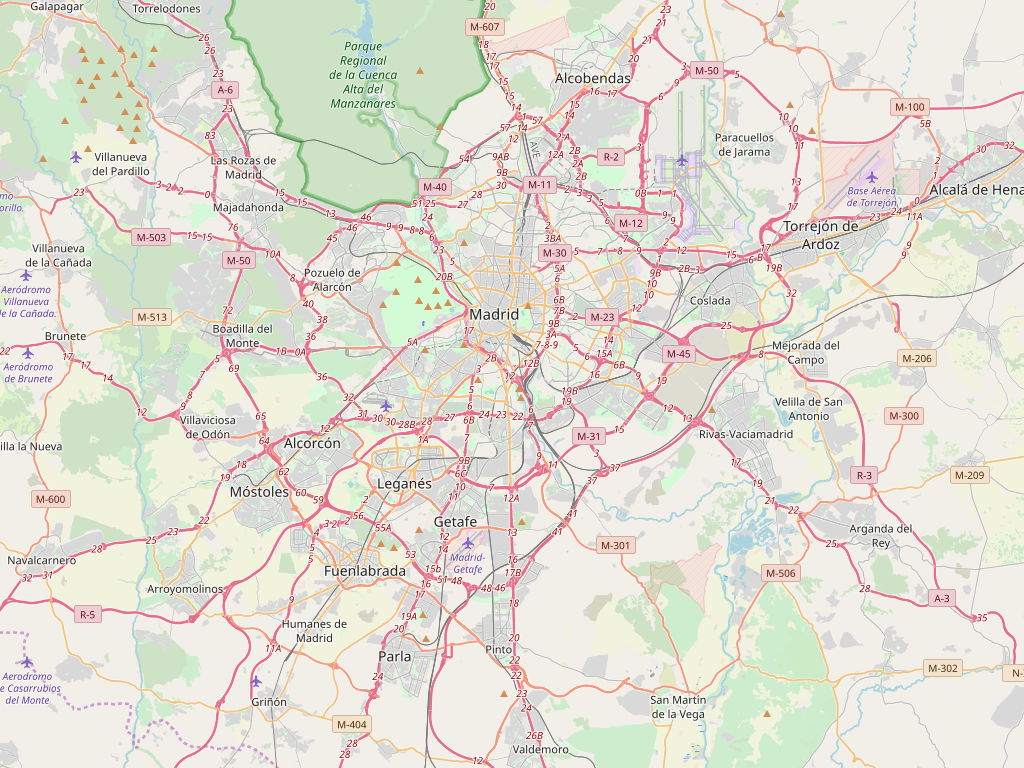

In [22]:
box = (lat_min, lon_min, lat_max, lon_max)
m = smopy.Map(box, z=11)
m.show_ipython()

In [23]:
df.head()

,Linea,Estacion,Latitud,Altitud
0,1,ALTO DEL ARENAL,40.389769,-3.645225
1,1,ALVARADO,40.450331,-3.703318
2,1,ANTON MARTIN,40.412463,-3.699376
3,1,ATOCHA,40.408847,-3.692491
4,1,ATOCHA RENFE,40.406586,-3.689380


In [24]:
vor = spatial.Voronoi(np.c_[df['Latitud'], df['Altitud']])

In [54]:
print(vor)

In [25]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    Source:
    [https://stackoverflow.com/a/20678647/1595060]
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    # Construct a map containing all ridges for a
    # given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points,
                                  vor.ridge_vertices):
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            # Compute the missing endpoint of an
            # infinite ridge
            t = vor.points[p2] - vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(
                np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

In [26]:
regions, vertices = voronoi_finite_polygons_2d(vor)
cells = [m.to_pixels(vertices[region])
         for region in regions]

In [27]:
cmap = plt.cm.Set3
# We generate colors for districts using a color map.
colors_districts = cmap(
    np.linspace(0., 1., len(df['Linea'].unique())))[:, :3]
# The color of every polygon, grey by default.
colors = .25 * np.ones((len(df['Linea'].unique()), 3))
# We give each polygon in Paris the color of
# its district.
colors= colors_districts

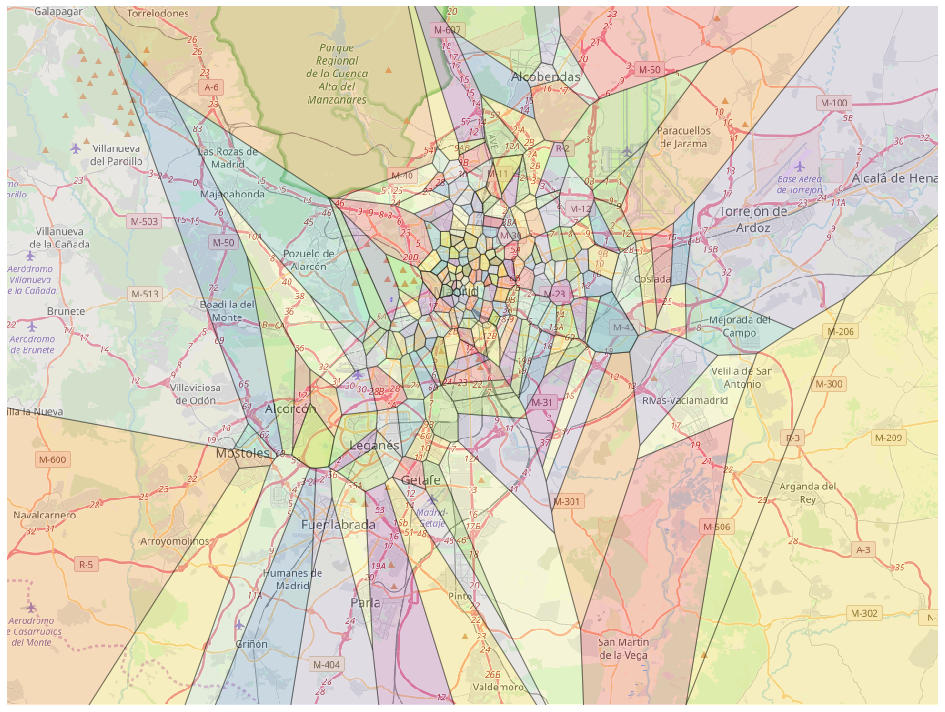

In [28]:
ax = m.show_mpl(figsize=(15, 10))
ax.add_collection(
    mpl.collections.PolyCollection(
        cells, facecolors=colors,
        edgecolors='k', alpha=.35))

### We now consider the number of travellers by line in 2017
-(source: https://www.metromadrid.es/es/portal_de_transparencia/inf_econ_presup_estad/datos_estadisticos/Demanda_mensual.html)

In [29]:
line_travels_2017 = {'1': 58497513, 
                '2': 28428456,
                '3': 40784052,
                '4': 27900476,
                '5': 36068762,
                '6': 66768788,
                '7': 27228389,
                '8': 7391731,
                '9': 27240787,
                '10': 46189671,
                '11': 3235636,
                '12': 22079315,
                'R': 3976031
               }

In [30]:
line_travels_2018 = {'1': 62659751, 
                '2': 28143224,
                '3': 42334637,
                '4': 28162515,
                '5': 45474628,
                '6': 68921255,
                '7': 28371552,
                '8': 12207580,
                '9': 27769424,
                '10': 48376811,
                '11': 3481717,
                '12': 21623381,
                'R': 4084371
               }

### And by stations

In [31]:
data = pd.read_csv(filepath_or_buffer='../Utilizaciones_estaciones_2017.csv', header=3, sep=';', encoding='utf-8')

In [32]:
data = data.drop('Orden 2017',1)

In [33]:
data = data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [34]:
data['Estacion'] = data['Estacion'].str.upper()

In [35]:
df.head()

,Linea,Estacion,Latitud,Altitud
0,1,ALTO DEL ARENAL,40.389769,-3.645225
1,1,ALVARADO,40.450331,-3.703318
2,1,ANTON MARTIN,40.412463,-3.699376
3,1,ATOCHA,40.408847,-3.692491
4,1,ATOCHA RENFE,40.406586,-3.689380


In [36]:
data.head()

,Estacion,Entradas
2,SOL,21936772.0
3,MONCLOA,19344895.0
4,PRINCIPE PIO,15727577.0
5,NUEVOS MINISTERIOS,15656389.0
6,AVENIDA DE AMERICA,12665592.0


There are some station names that differ from one data source to the other. Let's explore them and solve this problem

In [37]:
stations_in_data = [x for x in data['Estacion']]

In [38]:
stations_in_df = [x for x in df.sort_values('Estacion').Estacion]

In [39]:
dif1 = [x for x in stations_in_df if x not in stations_in_data]

In [40]:
dif2 = [x for x in stations_in_data if x not in stations_in_df]

In [41]:
df2 = df[df['Estacion'].isin(dif1)]

In [42]:
df3 = data[data['Estacion'].isin(dif2)]

In [43]:
dictionary_changes = {'AEROPUERTO T1 T2 T3':'AEROPUERTO T1-T2-T3',
                       'AEROPUERTO T4':'AEROPUERTO T-4',
                       'ATOCHA RENFE':'ATOCHA-RENFE',
                       'AVDA. DE LA ILUSTRACION':'AVENIDA DE LA ILUSTRACION',
                       'CAMPO DE LAS NACIONES':'FERIA DE MADRID',
                       'ESTADIO OLIMPICO':'ESTADIO METROPOLITANO',
                       'PARQUE LISBOA':'PARQUE DE LISBOA',
                       'VILLAVERDE BAJO CRUCE':'VILLAVERDE BAJO-CRUCE'}

In [44]:
df = df.replace({'Estacion': dictionary_changes})

In [45]:
traffic_dict = pd.Series(data.Entradas.values,index=data.Estacion).to_dict()

In [46]:
(traffic_dict)

{'SOL': 21936772.0,
 'MONCLOA': 19344895.0,
 'PRINCIPE PIO': 15727577.0,
 'NUEVOS MINISTERIOS': 15656389.0,
 'AVENIDA DE AMERICA': 12665592.0,
 'PLAZA DE CASTILLA': 12570086.0,
 'ATOCHA-RENFE': 8498093.0,
 'ARGUELLES': 8315587.0,
 'PLAZA DE ESPANA': 8124672.0,
 'MENDEZ ALVARO': 7708764.0,
 'CALLAO': 6977585.0,
 'CUATRO CAMINOS': 6921895.0,
 'LEGAZPI': 6685418.0,
 'GRAN VIA': 6473920.0,
 'GOYA': 6401035.0,
 'CHAMARTIN': 6241627.0,
 'PLAZA ELIPTICA': 6120400.0,
 'OPORTO': 6095001.0,
 'EMBAJADORES': 5976373.0,
 'DIEGO DE LEON': 5755484.0,
 'OPERA': 5609714.0,
 'ALONSO MARTINEZ': 5292049.0,
 'CONDE DE CASAL': 5135429.0,
 'COLONIA JARDIN': 5031032.0,
 'TRIBUNAL': 4983671.0,
 'CIUDAD UNIVERSITARIA': 4969832.0,
 'MANUEL BECERRA': 4643188.0,
 'BILBAO': 4642715.0,
 'PACIFICO': 4604390.0,
 'ESTRECHO': 4579135.0,
 'SANTIAGO BERNABEU': 4349908.0,
 'GREGORIO MARANON': 4345104.0,
 'USERA': 4266895.0,
 'ALUCHE': 4198230.0,
 'PINAR DE CHAMARTIN': 3889259.0,
 'COLOMBIA': 3873001.0,
 'ISLAS FILIPINAS': 

In [47]:
df['Entradas'] = df['Estacion']

In [48]:
df = df.replace({'Entradas':traffic_dict})

In [49]:
df.head()

,Linea,Estacion,Latitud,Altitud,Entradas
0,1,ALTO DEL ARENAL,40.389769,-3.645225,1856459.0
1,1,ALVARADO,40.450331,-3.703318,1879750.0
2,1,ANTON MARTIN,40.412463,-3.699376,2684716.0
3,1,ATOCHA,40.408847,-3.692491,2601095.0
4,1,ATOCHA-RENFE,40.406586,-3.689380,8498093.0


We add the traffic of passengers in each line to the DataFrame:

In [50]:
df['Trafico en la Linea'] = df['Linea']

In [51]:
df = df.replace({'Trafico en la Linea': line_travels_2017})

In [52]:
df[df['Linea'] == '2'].head()

,Linea,Estacion,Latitud,Altitud,Entradas,Trafico en la Linea
100,2,ALSACIA,40.418284,-3.623514,1666063.0,28428456
101,2,AVENIDA DE GUADALAJARA,40.422391,-3.612071,1134751.0,28428456
102,2,BANCO DE ESPANA,40.419219,-3.694966,3377198.0,28428456
103,2,CANAL,40.438406,-3.704337,2960961.0,28428456
104,2,CUATRO CAMINOS,40.446967,-3.703978,6921895.0,28428456
